# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for labels 0 (Normal conditions) and 2 (SPURIOUS CLOSURE OF DHSV).

In [41]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[0, 101, 1]

data_df = dset.get_df(label=[0, 1])
data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df[:10]

,ts,label,path,nlines
0,2017-02-07 08:01:24,0,..\dataset\0\WELL-00006_20170207080124.csv,17917
1,2017-08-19 05:00:00,0,..\dataset\0\WELL-00006_20170819050000.csv,17730
2,2017-02-19 17:00:53,0,..\dataset\0\WELL-00001_20170219170053.csv,17948
3,NaT,1,..\dataset\1\SIMULATED_00113.csv,88799
4,2017-09-15 07:00:00,0,..\dataset\0\WELL-00003_20170915070000.csv,17858
5,2017-04-01 17:00:00,0,..\dataset\0\WELL-00005_20170401170000.csv,17957
6,2017-05-09 00:00:53,0,..\dataset\0\WELL-00006_20170509000053.csv,17948
7,2014-08-07 12:01:12,0,..\dataset\0\WELL-00004_20140807120112.csv,7129
8,NaT,1,..\dataset\1\SIMULATED_00012.csv,88800
9,2017-08-12 19:00:00,0,..\dataset\0\WELL-00002_20170812190000.csv,17839


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [6]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [42]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2018-10-06 20:27:00 {'P-PDG': -1.1328992371117383, 'P-TPT': -0.4641281725492758, 'T-TPT': 0.511540278356744, 'P-MON-CKP': 1.0688929362406585, 'T-JUS-CKP': 0.40995590155677747, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 20:28:00 {'P-PDG': -1.1328992371117383, 'P-TPT': -0.46412912024611563, 'T-TPT': 0.5115514391289603, 'P-MON-CKP': 1.0688929362406585, 'T-JUS-CKP': 0.4099754823548977, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 20:29:00 {'P-PDG': -1.1328992371117383, 'P-TPT': -0.46413954491134546, 'T-TPT': 0.5115704694675726, 'P-MON-CKP': 1.0688929362406585, 'T-JUS-CKP': 0.4100096720826058, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-10-06 20:30:00 {'P-PDG': -1.1329079079074875, 'P-TPT': -0.46414390431680624, 'T-TPT': 0.5115892391166142, 'P-MON-CKP': 1.0688929362406585, 'T-JUS-CKP': 0.41004349937503953, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


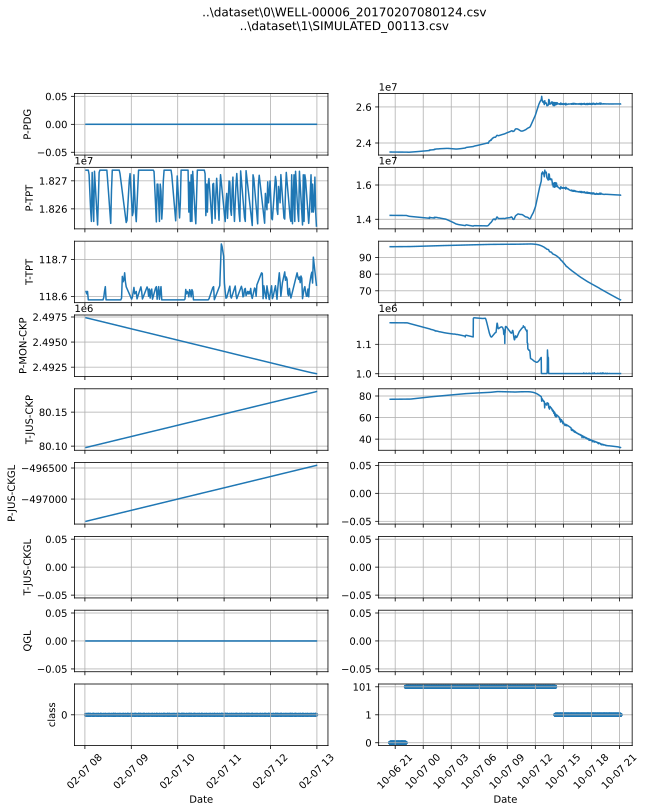

In [43]:
gen.plot([0,3])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [60]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

In [61]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
Basemodel = imblearn.RandomOverSampler(tree.HoeffdingTreeClassifier(delta=1.E-4),
            desired_dist={0: 0.4, 101: 0.3, 1: 0.3}, seed=200560)
model = deepcopy(Basemodel)
#model = imblearn.RandomOverSampler(multiclass.OneVsOneClassifier(linear_model.ALMAClassifier(alpha=0.85, B=1./0.85)),
#                                   desired_dist={0: 0.4, 102: 0.2, 2: 0.4}, seed=200560)

flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 30

i_s, ys, y_preds, accuracies, reports, ifiles, model, df = fit_model(data_df, flist, 'class', window_size,
                                                                     model, dfB=True, EvalB=False)
i_se, yse, y_predse, accuraciese, reportse, _, _ = fit_model(data_df, flist, 'class', window_size, 
                                                                    model, dfB=False, EvalB=True)    

files learned  726 / 726
 BalancedAccuracy: 92.42%

            Precision   Recall   F1       Support  
                                                  
     0.0      98.75%   97.53%   98.14%    158956  
     1.0      83.24%   90.01%   86.49%     48497  
   101.0      91.79%   89.72%   90.74%     87941  
                                                  
   Macro      91.26%   92.42%   91.79%            
   Micro      93.97%   93.97%   93.97%            
Weighted      94.13%   93.97%   94.02%            

                 93.97% accuracy                  
files learned  726 / 726
 BalancedAccuracy: 50.49%

            Precision   Recall   F1       Support  
                                                  
     0.0      60.33%   98.77%   74.91%    158956  
     1.0      74.11%   51.55%   60.80%     48497  
   101.0      71.74%    1.16%    2.28%     87941  
                                                  
   Macro      68.73%   50.49%   46.00%            
   Micro      61.96%   61.

In [62]:
model

RandomOverSampler (
  classifier=HoeffdingTreeClassifier (
    grace_period=200
    max_depth=inf
    split_criterion="info_gain"
    delta=0.0001
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
  desired_dist={0: 0.4, 101: 0.3, 1: 0.3}
  seed=200560
)

In [63]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    158956
         1.0       0.83      0.90      0.86     48497
       101.0       0.92      0.90      0.91     87941

    accuracy                           0.94    295394
   macro avg       0.91      0.92      0.92    295394
weighted avg       0.94      0.94      0.94    295394



In [64]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 15207
P-MON-CKP_rSEM 15207
P-MON-CKP_rMax 15207
P-MON-CKP_rMin 15207
T-JUS-CKP_rmean 22198
T-JUS-CKP_rSEM 22198
T-JUS-CKP_rMax 22198
T-JUS-CKP_rMin 22198
P-JUS-CKGL_rmean 181863
P-JUS-CKGL_rSEM 181863
P-JUS-CKGL_rMax 181863
P-JUS-CKGL_rMin 181863
QGL_rmean 181681
QGL_rSEM 181681
QGL_rMax 181681
QGL_rMin 181681
class 0
mean accuracy Random Forest:  0.9999526056724239
            var    varImp
3    P-PDG_rMin  0.199267
2    P-PDG_rMax  0.192659
1    P-PDG_rSEM  0.144867
10   T-TPT_rMax  0.099682
11   T-TPT_rMin  0.098019
8   T-TPT_rmean  0.087253
7    P-TPT_rMin  0.036501
4   P-TPT_rmean  0.035375
0   P-PDG_rmean  0.035303
6    P-TPT_rMax  0.025892
9    T-TPT_rSEM  0.024934
5    P-TPT_rSEM  0.020248
CPU times: total: 6.7 s
Wall time: 6.71 s


,var,varImp
0,P-PDG,0.572096
1,T-TPT,0.309888
2,P-TPT,0.118016


In [65]:
# Random Forest on validation set
print(classification_report(df['class'], forest.predict((df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    158956
         1.0       1.00      1.00      1.00     48497
       101.0       1.00      1.00      1.00     87941

    accuracy                           1.00    295394
   macro avg       1.00      1.00      1.00    295394
weighted avg       1.00      1.00      1.00    295394



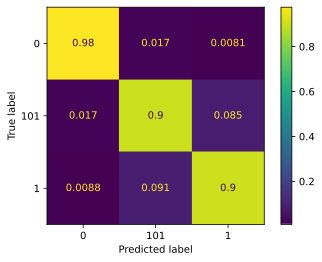

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_preds, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

## Drift test

In [67]:
def plot_acc(i_s, i_sD, accuracies, accuraciesD, dr, first, second):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title('Accuracies')
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
#     plt.grid()
    
    res = dr.to_df()
    res0 = res[res.change == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='green', alpha=0.25)
    res0 = res[res.new_model == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='red')
    plt.show()
    return

In [68]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'new_model': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change, new_model):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['new_model'].append(new_model)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)
    def get_changes(self):
        return sum(self.d['change'])

In [69]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, drd0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
        n_model = 0
#     drd = deepcopy(drd0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = deepcopy(drd0)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if hasattr(drd, "warning_detected") and drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                if n_model > 10000: # New model if at least 10000 instances has been learnt
                    model = deepcopy(model0) #model reinitialization
                    j = 0
                    n_model = 0
                    print('*** model reinitializated ***')
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, True)
                else:
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
                    
            n += 1

            if not EvalB:
                model.learn_one(xd, y)
                n_model += 1

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)
            
    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

### ADWIN

In [86]:
%%time

modelD = deepcopy(Basemodel)

#delta=0.002, clock=32, max_buckets=5, min_window_length=5, grace_period=10
drd = drift.ADWIN(delta=0.0001, clock=30, min_window_length=90, grace_period=120)
dr_ADWIN = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_ADWIN, drd, dfB=False, EvalB=False)    

files learned  4 / 726
Change detected at index 2275 1349, ifile 3, label 1 1.0 SIMULATED_00113
files learned  9 / 726
Change detected at index 3875 449, ifile 8, label 1 101.0 SIMULATED_00012
files learned  63 / 726
Change detected at index 24362 449, ifile 62, label 1 101.0 SIMULATED_00037
*** model reinitializated ***
files learned  75 / 726
Change detected at index 28885 509, ifile 74, label 1 1.0 SIMULATED_00075
files learned  81 / 726
Change detected at index 31265 749, ifile 80, label 1 101.0 SIMULATED_00034
files learned  97 / 726
Change detected at index 39721 1169, ifile 96, label 1 1.0 SIMULATED_00102
*** model reinitializated ***
files learned  110 / 726
Change detected at index 45710 449, ifile 109, label 1 101.0 SIMULATED_00040

Change detected at index 46610 1349, ifile 109, label 1 1.0 SIMULATED_00040
files learned  118 / 726
Change detected at index 49872 569, ifile 117, label 1 101.0 SIMULATED_00105

Change detected at index 50172 869, ifile 117, label 1 101.0 SIMULAT

In [87]:
print('Number of drift points detected: {}'.format(dr_ADWIN.get_changes()))

Number of drift points detected: 78


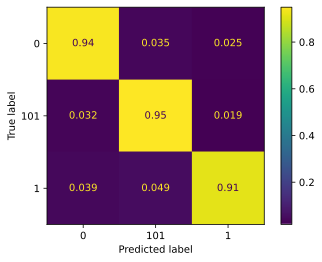

In [88]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

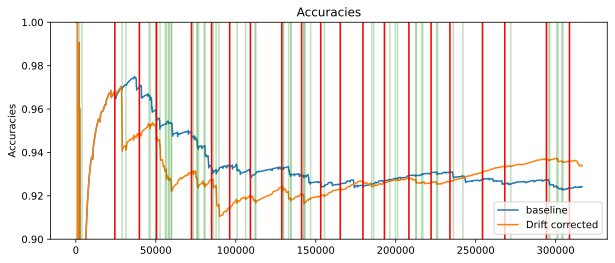

In [89]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_ADWIN, 'baseline', 'Drift corrected')

### DDM

In [91]:
modelD = deepcopy(Basemodel)

drd = drift.DDM(warm_start=250, warning_threshold=2.0, drift_threshold=3.0) #warm_start=30, warning_threshold=2.0, drift_threshold=3.0
dr_DDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_DDM, drd, dfB=False, EvalB=False)    

files learned  4 / 726
Warning detected at index 1961 1035, ifile 3, label 1 1.0 SIMULATED_00113

Change detected at index 1965 1039, ifile 3, label 1 1.0 SIMULATED_00113
files learned  28 / 726
Warning detected at index 10552 1049, ifile 27, label 1 1.0 SIMULATED_00065

Change detected at index 10566 1063, ifile 27, label 1 1.0 SIMULATED_00065
files learned  41 / 726
Warning detected at index 15068 1033, ifile 40, label 1 1.0 SIMULATED_00057

Change detected at index 15081 1046, ifile 40, label 1 1.0 SIMULATED_00057
*** model reinitializated ***
files learned  43 / 726
Warning detected at index 17146 1332, ifile 42, label 1 1.0 DRAWN_00002

Change detected at index 17154 1340, ifile 42, label 1 1.0 DRAWN_00002
files learned  48 / 726
Warning detected at index 18476 327, ifile 47, label 1 101.0 SIMULATED_00087

Change detected at index 18482 333, ifile 47, label 1 101.0 SIMULATED_00087

Warning detected at index 18742 593, ifile 47, label 1 1.0 SIMULATED_00087

Change detected at index

files learned  214 / 726
Warning detected at index 96021 1011, ifile 213, label 1 101.0 SIMULATED_00111

Change detected at index 96025 1015, ifile 213, label 1 101.0 SIMULATED_00111
files learned  216 / 726
Warning detected at index 97827 1035, ifile 215, label 1 1.0 SIMULATED_00016

Change detected at index 97831 1039, ifile 215, label 1 1.0 SIMULATED_00016
files learned  219 / 726
Warning detected at index 99906 1034, ifile 218, label 1 1.0 SIMULATED_00015

Change detected at index 99909 1037, ifile 218, label 1 1.0 SIMULATED_00015
files learned  220 / 726
Warning detected at index 100665 312, ifile 219, label 1 1.0 SIMULATED_00042

Change detected at index 100667 314, ifile 219, label 1 1.0 SIMULATED_00042
files learned  225 / 726
Warning detected at index 102733 542, ifile 224, label 1 101.0 SIMULATED_00092

Change detected at index 102734 543, ifile 224, label 1 101.0 SIMULATED_00092
files learned  232 / 726
Warning detected at index 105245 258, ifile 231, label 0 0.0 WELL-00003_

files learned  448 / 726
Warning detected at index 201224 496, ifile 447, label 1 101.0 SIMULATED_00049

Change detected at index 201227 499, ifile 447, label 1 101.0 SIMULATED_00049
files learned  452 / 726
Warning detected at index 202936 313, ifile 451, label 1 1.0 SIMULATED_00071

Change detected at index 202938 315, ifile 451, label 1 1.0 SIMULATED_00071
files learned  464 / 726
Warning detected at index 206687 312, ifile 463, label 1 1.0 SIMULATED_00076

Change detected at index 206688 313, ifile 463, label 1 1.0 SIMULATED_00076
files learned  465 / 726
Warning detected at index 208167 1032, ifile 464, label 1 1.0 SIMULATED_00038

Change detected at index 208168 1033, ifile 464, label 1 1.0 SIMULATED_00038
files learned  478 / 726
Warning detected at index 212373 660, ifile 477, label 1 101.0 SIMULATED_00052

Change detected at index 212507 794, ifile 477, label 1 1.0 SIMULATED_00052
*** model reinitializated ***
files learned  486 / 726
Warning detected at index 215719 793, ifil

files learned  706 / 726
Warning detected at index 306922 1033, ifile 705, label 1 1.0 SIMULATED_00017

Change detected at index 306925 1036, ifile 705, label 1 1.0 SIMULATED_00017
files learned  707 / 726
Warning detected at index 308408 1038, ifile 706, label 1 1.0 SIMULATED_00013

Change detected at index 308473 1103, ifile 706, label 1 1.0 SIMULATED_00013
files learned  714 / 726
Warning detected at index 310927 277, ifile 713, label 1 101.0 SIMULATED_00027

Change detected at index 310930 280, ifile 713, label 1 101.0 SIMULATED_00027

Warning detected at index 311208 558, ifile 713, label 1 101.0 SIMULATED_00027

Change detected at index 311217 567, ifile 713, label 1 101.0 SIMULATED_00027

Warning detected at index 311577 927, ifile 713, label 1 101.0 SIMULATED_00027
files learned  725 / 726
Warning detected at index 315730 1033, ifile 724, label 1 1.0 SIMULATED_00014

Change detected at index 315731 1034, ifile 724, label 1 1.0 SIMULATED_00014
*** model reinitializated ***
files

In [92]:
print('Number of drift points detected: {}'.format(dr_DDM.get_changes()))

Number of drift points detected: 135


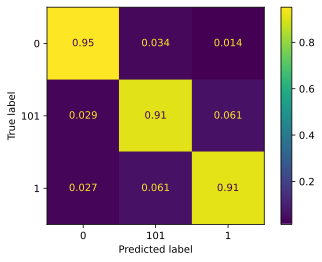

In [93]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

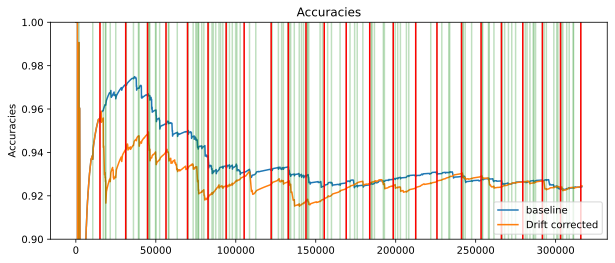

In [94]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_DDM, 'baseline', 'Drift corrected')

### EDDM

In [95]:
modelD = deepcopy(Basemodel)

drd = drift.EDDM(warm_start=120, alpha=0.95, beta=0.9) #warm_start=30, alpha=0.95, beta=0.9
dr_EDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_EDDM, drd, dfB=False, EvalB=False)    

files learned  100 / 726
Change detected at index 41307 674, ifile 99, label 1 1.0 SIMULATED_00082
*** model reinitializated ***
files learned  110 / 726
Change detected at index 45764 503, ifile 109, label 1 101.0 SIMULATED_00040

Change detected at index 46065 804, ifile 109, label 1 101.0 SIMULATED_00040
files learned  112 / 726
Change detected at index 47440 398, ifile 111, label 1 1.0 SIMULATED_00081
files learned  139 / 726
Change detected at index 59832 580, ifile 138, label 1 101.0 SIMULATED_00107
*** model reinitializated ***
files learned  175 / 726
Change detected at index 73200 275, ifile 174, label 1 101.0 SIMULATED_00032
*** model reinitializated ***
files learned  177 / 726
Warning detected at index 75270 143, ifile 176, label 0 0.0 WELL-00003_20170807100000

Change detected at index 75277 150, ifile 176, label 0 0.0 WELL-00003_20170807100000
files learned  196 / 726
Change detected at index 85017 855, ifile 195, label 1 101.0 SIMULATED_00033
*** model reinitializated **

In [96]:
print('Number of drift points detected: {}'.format(dr_EDDM.get_changes()))

Number of drift points detected: 37


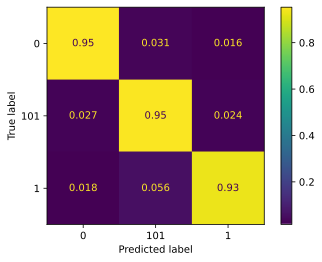

In [97]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

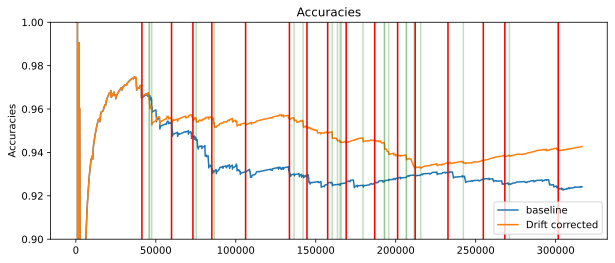

In [98]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_EDDM, 'baseline', 'Drift corrected')

### HDDM_A

In [99]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_A(drift_confidence=0.00005, warning_confidence=0.0001) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM_A = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                modelD, dr_HDDM_A, drd, dfB=False, EvalB=False)    

files learned  4 / 726
Change detected at index 1007 81, ifile 3, label 1 101.0 SIMULATED_00113

Change detected at index 1963 1037, ifile 3, label 1 1.0 SIMULATED_00113
files learned  9 / 726
Warning detected at index 4454 1028, ifile 8, label 1 101.0 SIMULATED_00012

Change detected at index 4455 1029, ifile 8, label 1 101.0 SIMULATED_00012
files learned  56 / 726
Warning detected at index 22163 214, ifile 55, label 0 0.0 WELL-00008_20170701090222

Change detected at index 22164 215, ifile 55, label 0 0.0 WELL-00008_20170701090222
*** model reinitializated ***
files learned  63 / 726
Change detected at index 23989 76, ifile 62, label 1 101.0 SIMULATED_00037

Warning detected at index 24948 1035, ifile 62, label 1 1.0 SIMULATED_00037

Change detected at index 24949 1036, ifile 62, label 1 1.0 SIMULATED_00037
files learned  65 / 726
Change detected at index 25616 103, ifile 64, label 0 0.0 WELL-00006_20170825160135

Warning detected at index 25778 265, ifile 64, label 0 0.0 WELL-00006_

files learned  220 / 726
Warning detected at index 100672 319, ifile 219, label 1 1.0 SIMULATED_00042

Change detected at index 100673 320, ifile 219, label 1 1.0 SIMULATED_00042

Warning detected at index 100859 506, ifile 219, label 1 1.0 SIMULATED_00042

Change detected at index 100860 507, ifile 219, label 1 1.0 SIMULATED_00042
files learned  223 / 726
Warning detected at index 101815 224, ifile 222, label 0 0.0 WELL-00005_20170403190000

Change detected at index 101816 225, ifile 222, label 0 0.0 WELL-00005_20170403190000
files learned  230 / 726
Change detected at index 104464 75, ifile 229, label 0 0.0 WELL-00006_20170822030000
files learned  234 / 726
Change detected at index 105839 253, ifile 233, label 0 0.0 WELL-00006_20170222150000
*** model reinitializated ***
files learned  236 / 726
Change detected at index 109666 899, ifile 235, label 1 101.0 SIMULATED_00110
files learned  237 / 726
Change detected at index 110382 134, ifile 236, label 0 0.0 WELL-00005_20170331210112

W

files learned  421 / 726
Warning detected at index 188173 147, ifile 420, label 1 101.0 SIMULATED_00035

Change detected at index 188174 148, ifile 420, label 1 101.0 SIMULATED_00035

Warning detected at index 188195 169, ifile 420, label 1 101.0 SIMULATED_00035

Change detected at index 188196 170, ifile 420, label 1 101.0 SIMULATED_00035

Change detected at index 189062 1036, ifile 420, label 1 1.0 SIMULATED_00035

Change detected at index 189325 1299, ifile 420, label 1 1.0 SIMULATED_00035
files learned  425 / 726
Change detected at index 190561 155, ifile 424, label 1 1.0 WELL-00001_20140124213136
files learned  426 / 726
Warning detected at index 190638 22, ifile 425, label 0 0.0 WELL-00002_20170216040141

Change detected at index 190639 23, ifile 425, label 0 0.0 WELL-00002_20170216040141
files learned  427 / 726
Change detected at index 191090 174, ifile 426, label 0 0.0 WELL-00002_20170618070105
files learned  431 / 726
Warning detected at index 192738 803, ifile 430, label 1 1

files learned  632 / 726
Change detected at index 275010 343, ifile 631, label 1 1.0 SIMULATED_00078
files learned  637 / 726
Warning detected at index 276689 67, ifile 636, label 0 0.0 WELL-00001_20170422040000

Change detected at index 276699 77, ifile 636, label 0 0.0 WELL-00001_20170422040000

Warning detected at index 276811 189, ifile 636, label 0 0.0 WELL-00001_20170422040000

Change detected at index 276812 190, ifile 636, label 0 0.0 WELL-00001_20170422040000
files learned  638 / 726
Change detected at index 277134 154, ifile 637, label 0 0.0 WELL-00001_20170202080239
files learned  641 / 726
Change detected at index 277966 91, ifile 640, label 0 0.0 WELL-00008_20170611180123
*** model reinitializated ***
files learned  651 / 726
Change detected at index 281010 330, ifile 650, label 1 1.0 DRAWN_00003
files learned  652 / 726
Warning detected at index 282077 1036, ifile 651, label 1 1.0 SIMULATED_00018

Change detected at index 282078 1037, ifile 651, label 1 1.0 SIMULATED_0001

In [100]:
print('Number of drift points detected: {}'.format(dr_HDDM_A.get_changes()))

Number of drift points detected: 209


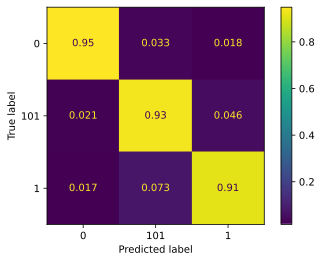

In [101]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

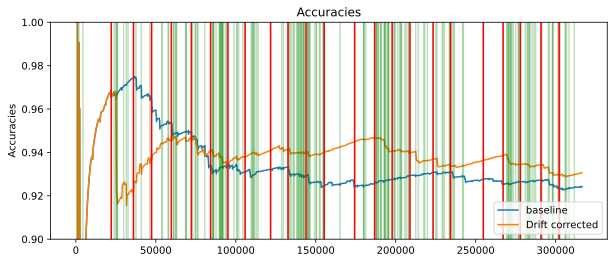

In [102]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM_A, 'baseline', 'Drift corrected')

### HDDM_W

In [103]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_W(drift_confidence=0.0001, warning_confidence=0.0005) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                            modelD, dr_HDDM, drd, dfB=False, EvalB=False)    

files learned  4 / 726
Warning detected at index 1014 88, ifile 3, label 1 101.0 SIMULATED_00113

Change detected at index 1016 90, ifile 3, label 1 101.0 SIMULATED_00113

Change detected at index 1958 1032, ifile 3, label 1 1.0 SIMULATED_00113
files learned  9 / 726
Change detected at index 4348 922, ifile 8, label 1 101.0 SIMULATED_00012
files learned  28 / 726
Change detected at index 10534 1031, ifile 27, label 1 1.0 SIMULATED_00065
files learned  43 / 726
Change detected at index 17139 1325, ifile 42, label 1 1.0 DRAWN_00002
*** model reinitializated ***
files learned  48 / 726
Warning detected at index 18480 331, ifile 47, label 1 101.0 SIMULATED_00087

Change detected at index 18481 332, ifile 47, label 1 101.0 SIMULATED_00087

Warning detected at index 18714 565, ifile 47, label 1 1.0 SIMULATED_00087

Change detected at index 18717 568, ifile 47, label 1 1.0 SIMULATED_00087
files learned  56 / 726
Warning detected at index 22155 206, ifile 55, label 0 0.0 WELL-00008_20170701090

files learned  197 / 726
Warning detected at index 85897 254, ifile 196, label 1 101.0 SIMULATED_00072

Change detected at index 86033 390, ifile 196, label 1 1.0 SIMULATED_00072
files learned  199 / 726
Warning detected at index 87085 386, ifile 198, label 1 101.0 SIMULATED_00039

Change detected at index 87088 389, ifile 198, label 1 101.0 SIMULATED_00039

Warning detected at index 87467 768, ifile 198, label 1 101.0 SIMULATED_00039

Change detected at index 87469 770, ifile 198, label 1 101.0 SIMULATED_00039

Warning detected at index 87633 934, ifile 198, label 1 101.0 SIMULATED_00039

Change detected at index 87636 937, ifile 198, label 1 101.0 SIMULATED_00039

Warning detected at index 87746 1047, ifile 198, label 1 1.0 SIMULATED_00039

Change detected at index 87748 1049, ifile 198, label 1 1.0 SIMULATED_00039
files learned  201 / 726
Warning detected at index 88565 87, ifile 200, label 1 101.0 SIMULATED_00019

Change detected at index 88567 89, ifile 200, label 1 101.0 SIMULATE

files learned  375 / 726
Warning detected at index 169111 620, ifile 374, label 1 1.0 SIMULATED_00085

Change detected at index 169112 621, ifile 374, label 1 1.0 SIMULATED_00085
files learned  381 / 726
Warning detected at index 171435 566, ifile 380, label 1 1.0 SIMULATED_00047

Change detected at index 171438 569, ifile 380, label 1 1.0 SIMULATED_00047
files learned  384 / 726
Warning detected at index 172733 264, ifile 383, label 0 0.0 WELL-00008_20170914070222
files learned  387 / 726
Warning detected at index 173870 506, ifile 386, label 1 101.0 SIMULATED_00005

Change detected at index 173872 508, ifile 386, label 1 101.0 SIMULATED_00005

Warning detected at index 173940 576, ifile 386, label 1 101.0 SIMULATED_00005

Change detected at index 173943 579, ifile 386, label 1 101.0 SIMULATED_00005

Warning detected at index 174169 805, ifile 386, label 1 1.0 SIMULATED_00005

Change detected at index 174172 808, ifile 386, label 1 1.0 SIMULATED_00005
files learned  389 / 726
Change d

files learned  538 / 726
Warning detected at index 234239 45, ifile 537, label 0 0.0 WELL-00005_20170816020000

Change detected at index 234243 49, ifile 537, label 0 0.0 WELL-00005_20170816020000

Warning detected at index 234303 109, ifile 537, label 0 0.0 WELL-00005_20170816020000

Change detected at index 234311 117, ifile 537, label 0 0.0 WELL-00005_20170816020000
files learned  542 / 726
Change detected at index 236182 1032, ifile 541, label 1 1.0 SIMULATED_00064
files learned  546 / 726
Warning detected at index 237676 149, ifile 545, label 0 0.0 WELL-00008_20170630030222

Change detected at index 237679 152, ifile 545, label 0 0.0 WELL-00008_20170630030222
files learned  558 / 726
Warning detected at index 242281 715, ifile 557, label 1 1.0 SIMULATED_00021

Change detected at index 242284 718, ifile 557, label 1 1.0 SIMULATED_00021
*** model reinitializated ***
files learned  561 / 726
Warning detected at index 242831 86, ifile 560, label 1 101.0 SIMULATED_00061

Change detecte

In [104]:
print('Number of drift points detected: {}'.format(dr_HDDM.get_changes()))

Number of drift points detected: 193


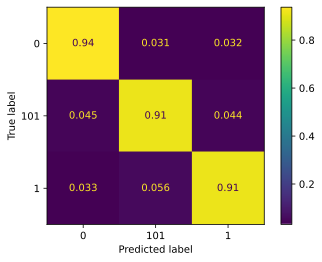

In [105]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

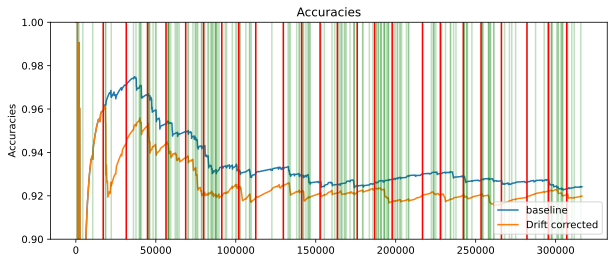

In [106]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM, 'baseline', 'Drift corrected')

### Comparación de detecciones de drift

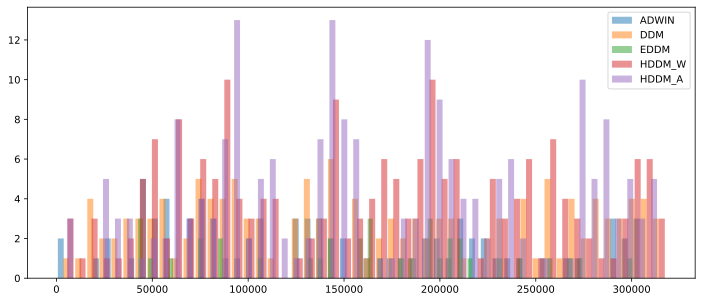

In [107]:
fig, ax = plt.subplots(figsize=(12,5))

res = dr_ADWIN.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='left', label='ADWIN')
res = dr_DDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='DDM')
res = dr_EDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='EDDM')
res = dr_HDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_W')
res = dr_HDDM_A.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_A')
ax.legend()
plt.show()

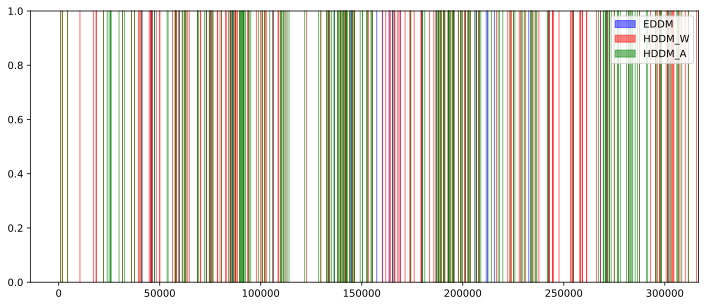

In [108]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,5))

res = dr_EDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='blue', alpha=0.75, linewidth=0.75)
res = dr_HDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='red', alpha=0.75, linewidth=0.75)
res = dr_HDDM_A.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='green', alpha=0.75, linewidth=0.75)

red_patch = mpatches.Patch(color='red', alpha=0.5, label='HDDM_W')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='EDDM')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='HDDM_A')
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='upper right')
    
plt.show()